### Packages

In [103]:
# Essentials
import pandas as pd
import numpy as np

# ML Modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# For preprosessing
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# For testing coherence model
import gensim
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Graphs
import matplotlib.pyplot as plt

### Data Import

In [3]:
url = 'https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/10-Natural-Language-Processing/lda_data'

data = pd.read_csv(url, sep=",", header=None)
data.columns = ['text']
data.head()

,text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...


### Preprocessing

In [6]:
def preprocessing(sentence):
    
    # remove whitespace
    sentence = sentence.strip()
    
    # lowercase characters
    sentence = sentence.lower()
    
    # remove numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    # remove punctuation
    for punctuation in string.punctuation:   
        sentence = sentence.replace(punctuation, '')
    
    # remove stop_words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    sentence = ' '.join(filtered_words)
    
    # tokenize and lemmatize
    words = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_words]  # Lemmatize nouns
    
    return ' '.join(lemmatized_words)

Test data:

In [7]:
data['clean_text'] = data['text'].apply(preprocessing)
data

,text,clean_text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,gldcunixbcccolumbiaedu gary l dare subject sta...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...,minerkuhubccukansedu subject ancient book orga...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...,vzhivovsuperiorcarletonca vladimir zhivov subj...
...,...,...
1194,From: jerryb@eskimo.com (Jerry Kaufman)\nSubje...,jerrybeskimocom jerry kaufman subject prayer a...
1195,From: golchowy@alchemy.chem.utoronto.ca (Geral...,golchowyalchemychemutorontoca gerald olchowy s...
1196,From: jayne@mmalt.guild.org (Jayne Kulikauskas...,jaynemmaltguildorg jayne kulikauskas subject q...
1197,From: sclark@epas.utoronto.ca (Susan Clark)\nS...,sclarkepasutorontoca susan clark subject pick ...


### Functions

In [96]:
def lda_model_fit(n_components, max_iter, vectorized_documents):
    lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = max_iter) 
    
    # Fit the LDA on the vectorized documents 
    lda_model.fit(vectorized_documents)
    
    return lda_model

In [97]:
def topics_list(model, vectorizer, top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        # print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_words - 1:-1]]
        # print(topic)
        topics.append(topic)
    return topics

In [98]:
def print_topics(model, vectorizer):
    topics = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
        print(topic)
        topics.append(topic)
    return topics

In [104]:
def graph_topics(topics):
    # Calculating the number of rows and columns
    num_sets = len(topics)
    num_cols = 2  # Number of columns you want
    num_rows = -(-num_sets // num_cols)  # Ceiling division to ensure enough rows
    
    # Plotting each data set
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    for i, data in enumerate(topics):
        row = i // num_cols
        col = i % num_cols
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        axs[row, col].barh(labels, values, color='skyblue')
        axs[row, col].set_ylabel('Keywords')
        axs[row, col].set_title('Topic {}'.format(i))
        axs[row, col].invert_yaxis()
    
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

### Run LDA to see the topics

In [20]:
vectorizer = TfidfVectorizer(min_df = 0.10, max_df = 0.9, max_features = 200)

vectorized_documents = vectorizer.fit_transform(data['clean_text'])

In [69]:
vectorized_documents.shape

(1199, 156)

In [40]:
# Instantiate the LDA
n_components = 5 
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100) 

# Fit the LDA on the vectorized documents 
lda_model.fit(vectorized_documents)

LatentDirichletAllocation(max_iter=100, n_components=5)

In [82]:
model1 = lda_model_fit(3, 100, vectorized_documents)

In [83]:
topics1 = print_topics(model1, vectorizer)

Topic 0:
[('team', 77.52634241679212), ('game', 77.16633960418677), ('play', 58.53300182443456), ('go', 57.21104476407408), ('hockey', 55.24823883536457), ('player', 51.32112851451826), ('win', 42.990418706727546), ('get', 42.418817776025804), ('nntppostinghost', 42.03215560152272), ('playoff', 40.80956970919782)]
Topic 1:
[('university', 37.45926694311636), ('hell', 34.53783673160102), ('please', 31.767617323114113), ('post', 29.377386929821355), ('state', 27.701781076686917), ('thank', 25.627339153038363), ('anyone', 25.349940297171898), ('science', 25.13381526483785), ('replyto', 14.845780353437855), ('world', 9.353285849471245)]
Topic 2:
[('god', 92.59505379537089), ('christian', 59.89984134033112), ('people', 50.91382698645575), ('would', 48.63567417982592), ('one', 47.96318675218559), ('church', 47.47410680961147), ('jesus', 47.41661510727497), ('say', 47.296143365336526), ('know', 44.16533373411294), ('believe', 41.136844187126705)]


In [86]:
topics1

[[('team', 77.52634241679212),
  ('game', 77.16633960418677),
  ('play', 58.53300182443456),
  ('go', 57.21104476407408),
  ('hockey', 55.24823883536457),
  ('player', 51.32112851451826),
  ('win', 42.990418706727546),
  ('get', 42.418817776025804),
  ('nntppostinghost', 42.03215560152272),
  ('playoff', 40.80956970919782)],
 [('university', 37.45926694311636),
  ('hell', 34.53783673160102),
  ('please', 31.767617323114113),
  ('post', 29.377386929821355),
  ('state', 27.701781076686917),
  ('thank', 25.627339153038363),
  ('anyone', 25.349940297171898),
  ('science', 25.13381526483785),
  ('replyto', 14.845780353437855),
  ('world', 9.353285849471245)],
 [('god', 92.59505379537089),
  ('christian', 59.89984134033112),
  ('people', 50.91382698645575),
  ('would', 48.63567417982592),
  ('one', 47.96318675218559),
  ('church', 47.47410680961147),
  ('jesus', 47.41661510727497),
  ('say', 47.296143365336526),
  ('know', 44.16533373411294),
  ('believe', 41.136844187126705)]]

In [94]:
topics = topics_list(lda_model, vectorizer, 5)

In [70]:
type(topics)

list

In [76]:
type(topics[0])

list

In [77]:
type(topics[0][0])

tuple

In [78]:
topics[0][0]

('name', 29.173949181121092)

In [74]:
len(topics)

5

In [75]:
topics

[[('name', 29.173949181121092),
  ('fan', 2.9975250073677477),
  ('like', 1.8111830960960629),
  ('cant', 1.2633818593976753),
  ('try', 0.8798763292386389),
  ('player', 0.7661226032126869),
  ('university', 0.7615216945899945),
  ('good', 0.7435928375581566),
  ('know', 0.5957952631077141),
  ('say', 0.5557652972183227)],
 [('church', 8.168604837722954),
  ('world', 4.461748757410106),
  ('replyto', 2.7565846185475524),
  ('game', 2.7305074566712997),
  ('anyone', 2.506375382583701),
  ('show', 2.2480285037933028),
  ('another', 2.2480231814738114),
  ('university', 2.08388548332709),
  ('would', 1.8804196052157496),
  ('bible', 1.701375227612775)],
 [('please', 25.107888880007135),
  ('thank', 19.348272412172385),
  ('university', 14.811721647085578),
  ('post', 9.905687491299032),
  ('pittsburgh', 8.958080375060495),
  ('nntppostinghost', 6.699890502577248),
  ('anyone', 6.0294331211691645),
  ('state', 4.018789664717768),
  ('replyto', 3.8436525929691268),
  ('time', 3.30373169974

In [45]:
lda_model.components_.shape

(5, 156)

In [50]:
vectorizer.get_feature_names_out().shape

(156,)

In [68]:
lda_model.components_[1].sum()

71.11508219042226

### Latent Dirichlet Allocation model for optimal number of topics (using Perplexity)

In [22]:
corpus = gensim.matutils.Sparse2Corpus(vectorized_documents, documents_columns=False)

In [24]:
dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(vectorizer.get_feature_names_out())))

In [25]:
# Function to compute perplexity values for a given LDA model
def compute_perplexity_values(corpus, dictionary, limit, start=2, step=3):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        perplexity_values.append(model.log_perplexity(corpus))
    return perplexity_values

In [28]:
def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=3):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

In [33]:
# Calculate perplexity values for different numbers of topics
start = 20
limit = 60
step = 2
perplexity_values = compute_perplexity_values(corpus, dictionary, limit, start, step)

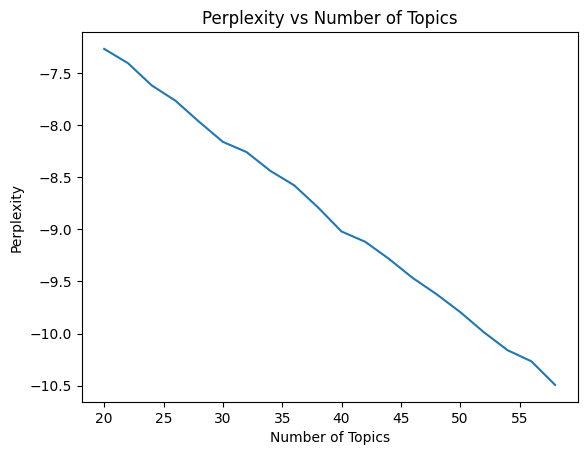

In [34]:
# Plot perplexity values
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Number of Topics")
plt.show()

### Visualization

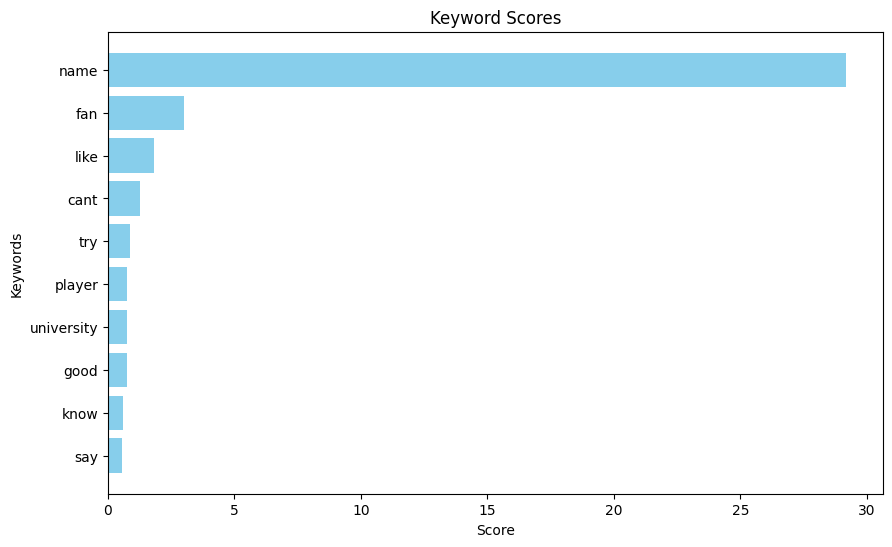

In [84]:
data = topics[0]

labels = [item[0] for item in data]
values = [item[1] for item in data]

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Keywords')
plt.title('Keyword Scores')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

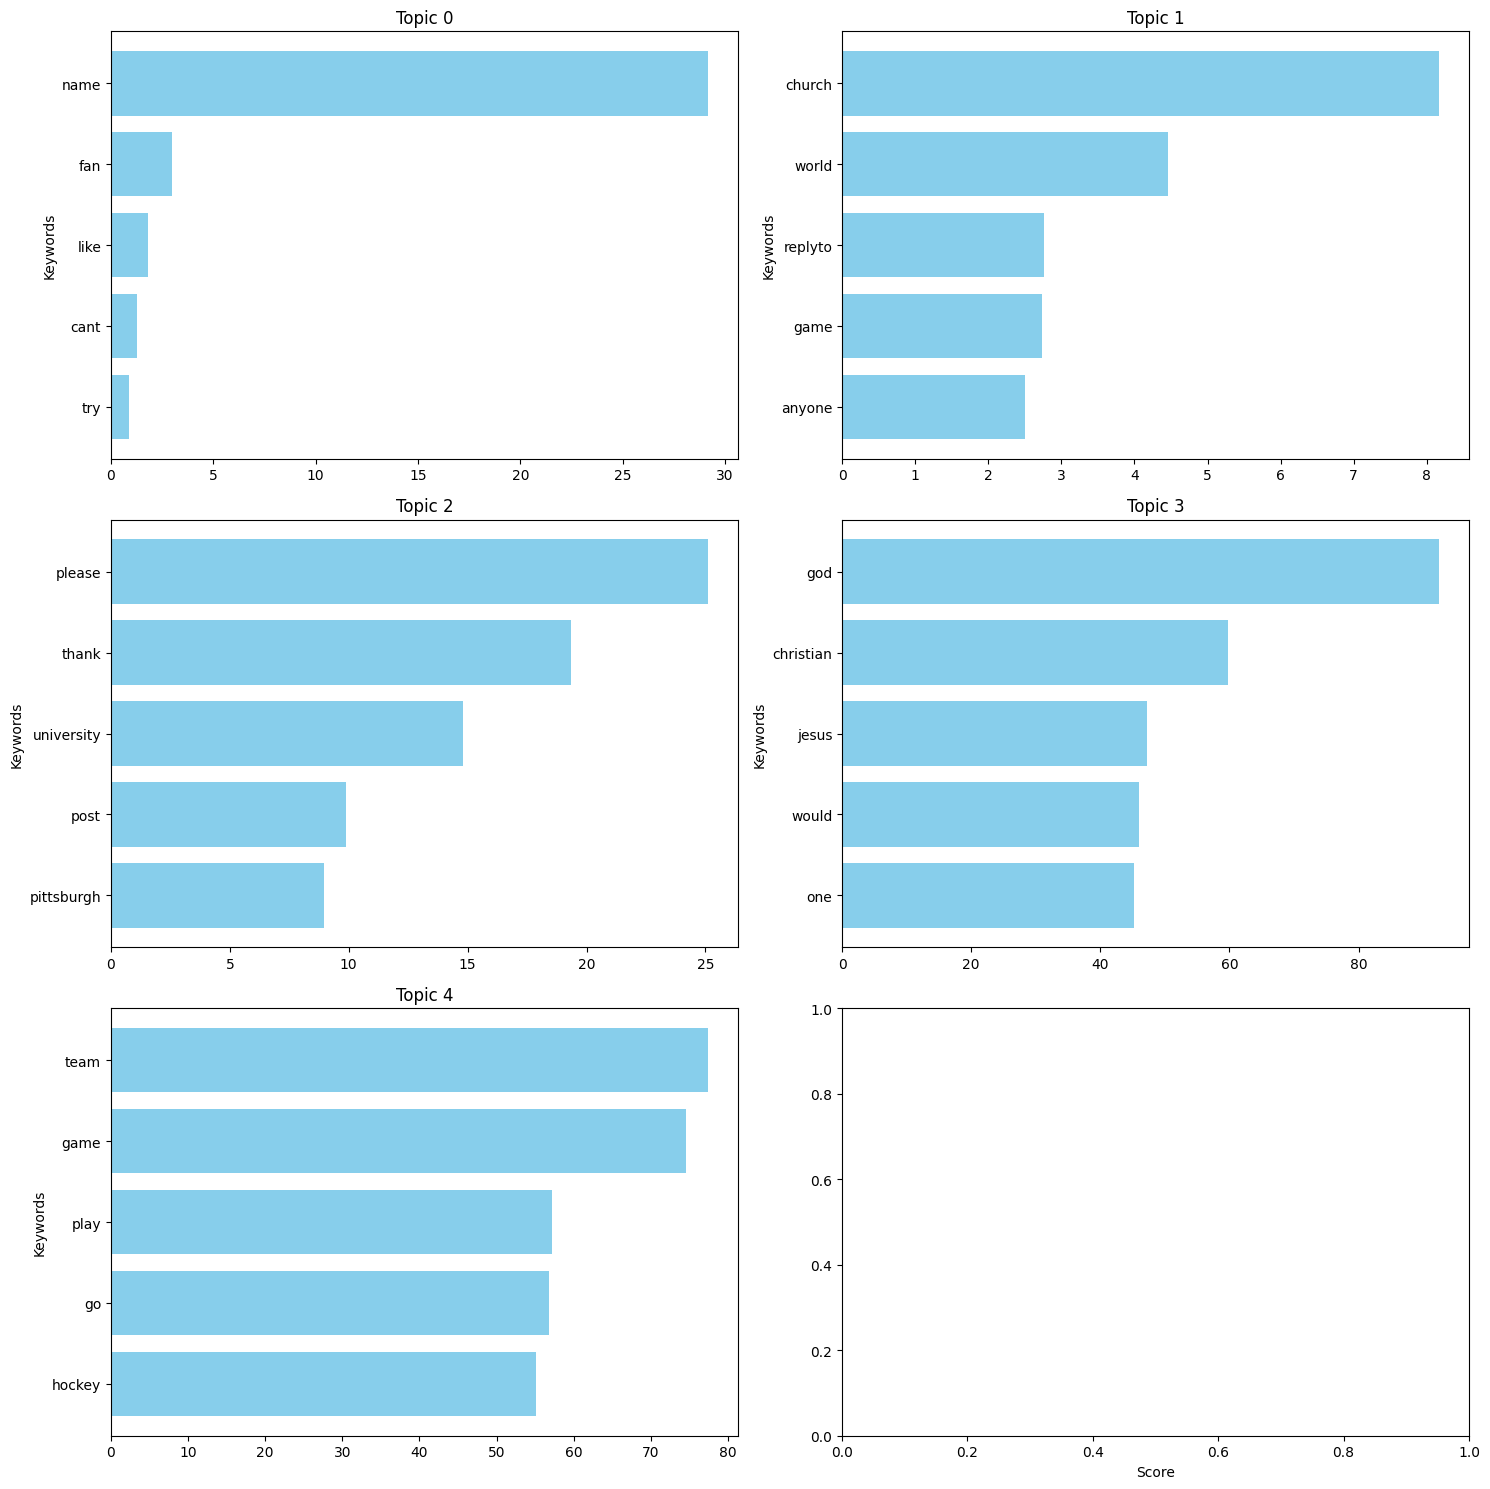

In [105]:
graph_topics(topics)